In [6]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from deepbrain import Extractor

from utils.s3.s3 import *

# %load_ext autoreload
# %autoreload 2

In [5]:
def show_slices(slices,img):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    fig.set_size_inches(11,8)
    for i, slice in enumerate(slices):

        axes[i].imshow(slice.T, cmap="gray", origin="lower")
    plt.suptitle(f"Center slices for current MRI image \n Image size: {img.shape}",fontsize=20)
    # print("image size:",img.shape)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.20)
    plt.show()

def show_brain_center_slice(img: np.memmap):
    slice_0 = img[int(img.shape[0]/2), :, :]
    slice_1 = img[:, int(img.shape[1]/2), :]
    slice_2 = img[:, :, int(img.shape[2]/2)]
    show_slices([slice_0, slice_1, slice_2],img)

# img_stripped = img.copy()
# img_stripped[~mask] = 0

# Building S3 pre processing pipeline

In [11]:
def set_env_variables():
    print("Setting ANTs and NiftyReg environment variables...\n")
    os.environ['ANTSPATH'] = '/home/lucasthim1/ants/ants_install/bin'
    os.environ['PATH'] =os.environ['PATH'] +  ":" + os.environ['ANTSPATH']
    os.environ['NIFTYREG_INSTALL'] = '/home/lucasthim1/niftyreg/niftyreg_install'
    os.environ['PATH'] = os.environ['PATH'] +  ":" + os.environ['NIFTYREG_INSTALL'] + '/bin'
 

def apply_full_s3_skull_stripping(input_path,output_path):
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    start = time.time()
    skull_stripper = SkullStripper(input_path, output_path, want_tissues=False, want_atlas=False)
    skull_stripper.strip_skull()
    total_time = (time.time() - start) / 60.
    print('Done! Process took %.2f min)' % total_time)

def apply_skull_stripping(input_path, output_path,type = 'simple'):
    '''
    Skull Stripping Registration procedure for MRI data.

    Arguments:

    input_path: input path of the image to be registered
    
    output_path: output directory to save the registered image

    type: registration type. Values can be ['rigid_refined','affine_refined','simple']
    '''

    input_path = os.path.abspath(input_path)
    if output_path is None:
        output_path = os.path.dirname(os.path.abspath(input_path))
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)
    output_path = os.path.abspath(output_path)
    
    start = time.time()
    skull_stripper = SkullStripper(input_path, output_path, want_tissues=True, want_atlas=False)
    if type == 'affine_refined':
        print("Executing Affine Registration... \n")
        skull_stripper.strip_skull()
    elif type == 'rigid_refined':
        print("Executing Rigid Registration... \n")
        skull_stripper.rigid_strip_skull()
    elif type == 'simple':
        print("Executing Simple Rigid Registration... \n")
        skull_stripper.simple_strip_skull()
    else:
        raise Exception("Please select a valid type of skull stripping registration: ['rigid_refined','affine_refined','simple']")

    print('Done! Process took %.2f min)' % ((time.time() - start) / 60.))
    

def apply_deep_brain_skull_stripping(input_path):
    
    # Load a nifti as 3d numpy image [H, W, D]
    img = nib.load(input_path).get_fdata()

    ext = Extractor()

    # `prob` will be a 3d numpy image containing probability 
    # of being brain tissue for each of the voxels in `img`
    prob = ext.run(img) 

    # mask can be obtained as:
    mask = prob > 0.5
    return img[mask],mask

In [4]:
set_env_variables()

Setting ANTs and NiftyReg environment variables...



In [5]:
# !python ./../process_images/s3/s3.py -i "/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"

In [9]:
main_dir = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/'

## Checking image and masks - Patient 002_S_4225

### Raw image

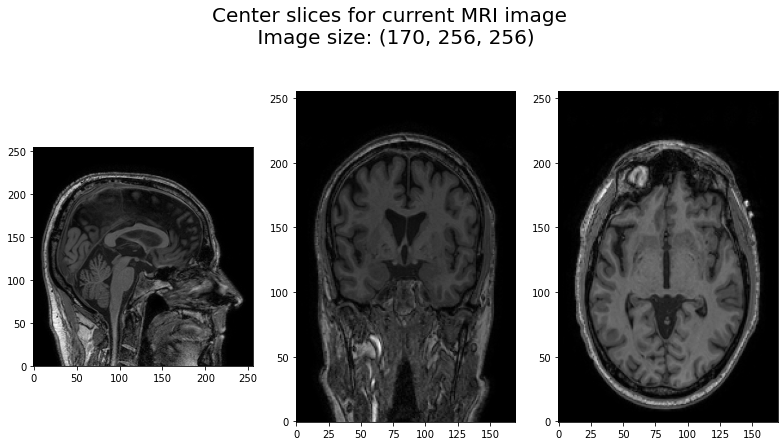

In [9]:
input_path = main_dir + "002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

### Simple skull stripping image (only first step of rigid transformation)

In [11]:
input_path = main_dir + "002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"
output_path = main_dir + "/Registered/002_S_4225_simple"
apply_skull_stripping(input_path,output_path,type='simple')

Creating output path... 

Executing Simple Rigid Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_simple 


Compute basic mask: 
 -----------------
Results save as /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_simple/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_masked_basic.nii.gz 

---------------------------
Skull Stripping Finished.
Done! Process took 0.13 min)


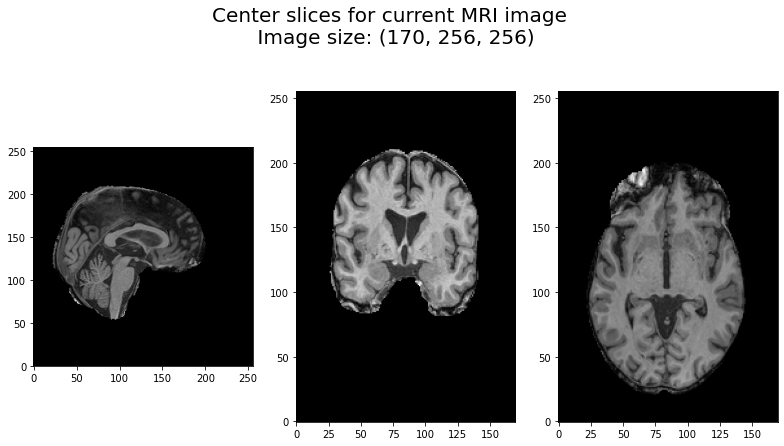

In [23]:
simple_ss = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_simple/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_masked_basic.nii.gz'
img = nib.load(simple_ss).get_fdata()
show_brain_center_slice(img)

### Complete Rigid Transformation with tissue segmentation overlay for better accuracy

In [26]:
input_path = main_dir + "002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"
output_path = main_dir + "/Registered/002_S_4225_rigid"
apply_skull_stripping(input_path,output_path,type='rigid_refined')

Executing Rigid Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_rigid 


Compute basic mask: 
 -----------------

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_rigid/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_masked.nii.gz 

---------------------------
 Rigid Skull Stripping Finished.
Done! Process took 0.15 min)


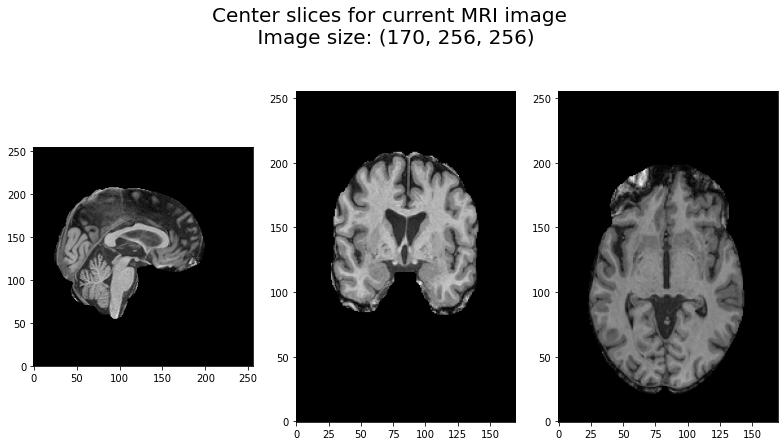

In [35]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_rigid/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_masked.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

### Complete Affine Transformation with tissue segmentation overlay for better accuracy

In [15]:
input_path = main_dir + "002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"
output_path = main_dir + "/Registered/002_S_4225_affine"
apply_skull_stripping(input_path,output_path,type='affine_refined')

Creating output path... 

Executing Affine Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_csf.nii.gz
gm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_gm.nii.gz
wm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_

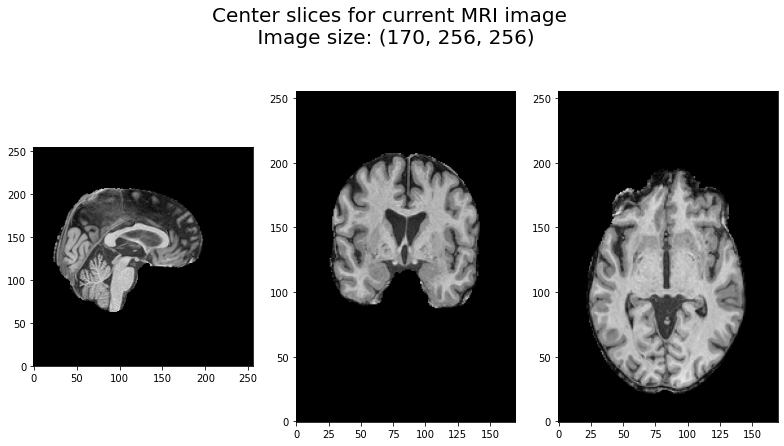

In [22]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_masked_basic.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

## Patient 002_S_4171

### Raw image

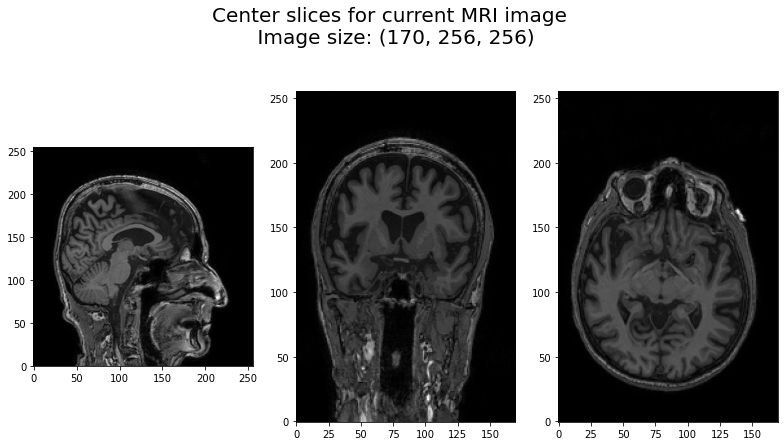

In [10]:
input_path = main_dir + "002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii"
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

### Affine Registration

In [37]:
input_path = main_dir + "002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii"
output_path = main_dir + "/Registered/002_S_4171_affine"
apply_skull_stripping(input_path,output_path,type='affine_refined')

Creating output path... 

Executing Affine Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_csf.nii.gz
gm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_gm.nii.gz
wm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine/ADNI_002_S_

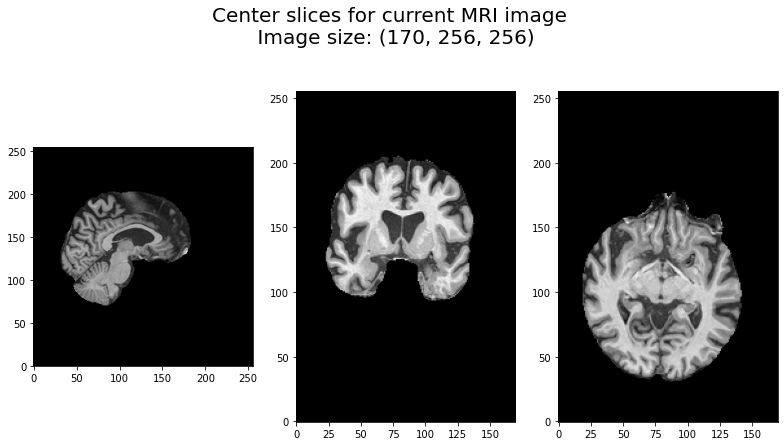

In [40]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

### Rigid Registration

In [38]:
input_path = main_dir + "002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii"
output_path = main_dir + "/Registered/002_S_4171_rigid"
apply_skull_stripping(input_path,output_path,type='rigid_refined')

Creating output path... 

Executing Rigid Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_rigid 


Compute basic mask: 
 -----------------

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_rigid/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked.nii.gz 

---------------------------
 Rigid Skull Stripping Finished.
Done! Process took 0.16 min)


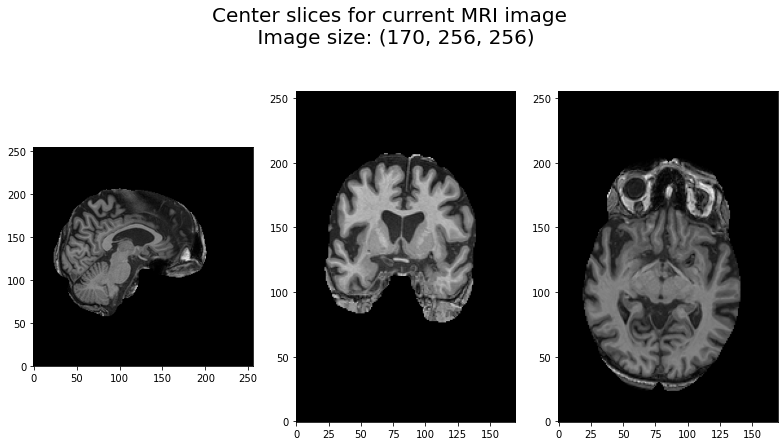

In [42]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_rigid/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

In [43]:
input_path = main_dir + "002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii"
output_path = main_dir + "/Registered/002_S_4171_simple"
apply_skull_stripping(input_path,output_path,type='simple')

Creating output path... 

Executing Simple Rigid Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_simple 


Compute basic mask: 
 -----------------
Results save as /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_simple/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked_basic.nii.gz 

---------------------------
Skull Stripping Finished.
Done! Process took 0.15 min)


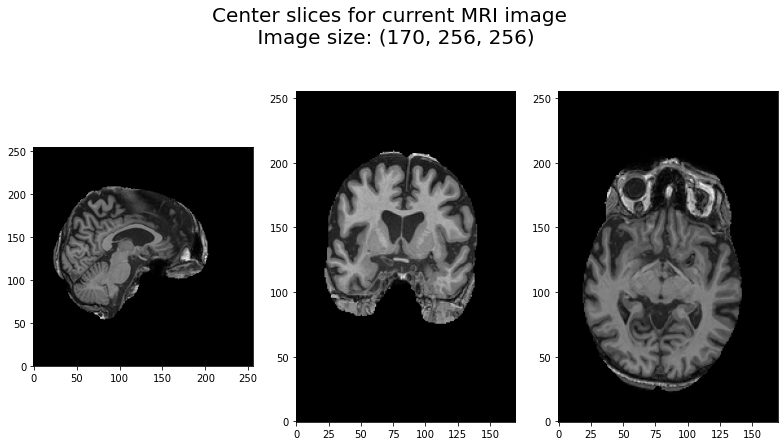

In [44]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_simple/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked_basic.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

For now, it looks like the affine registration removes nervous and eye tissues better from the image. 

Try the eye and face mask from the template I downloaded 

In [ ]:
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

## Checking image and masks - Patient 941_S_5193

In [9]:
main_dir

'/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/'

In [ ]:
import ants
import numpy as np

img1 = ants.image_read( ants.get_ants_data('r16') )
img2 = ants.image_read( ants.get_ants_data('r27') )
img3 = ants.image_read( ants.get_ants_data('r64') )

In [23]:
os.listdir('/home/lucasthim1/alzheimer_bucket/SAMPLE_UPLOAD_GCLOUD/941_S_5193/MT1__GradWarp__N3m/2013-05-29_12_07_08.0/S190909')

['ADNI_941_S_5193_MR_MT1__GradWarp__N3m_Br_20130607141303545_S190909_I375627.nii']

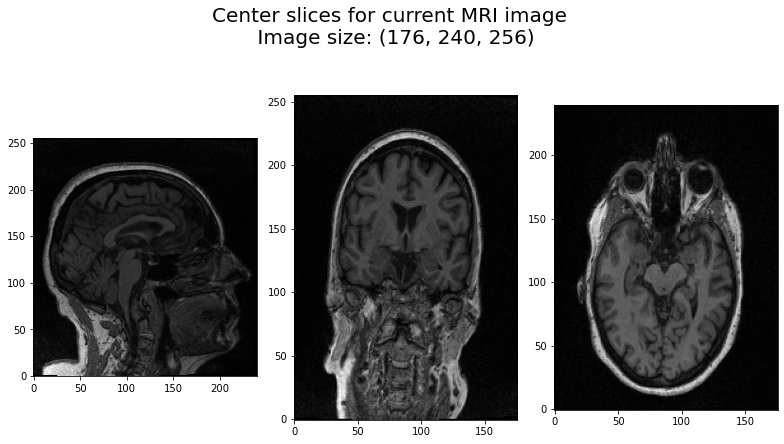

In [24]:
main_dir = '/home/lucasthim1/alzheimer_bucket/SAMPLE_UPLOAD_GCLOUD'
input_path = '/home/lucasthim1/alzheimer_bucket/SAMPLE_UPLOAD_GCLOUD/941_S_5193/MT1__GradWarp__N3m/2013-05-29_12_07_08.0/S190909/ADNI_941_S_5193_MR_MT1__GradWarp__N3m_Br_20130607141303545_S190909_I375627.nii'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

## Checking Registration Atlas

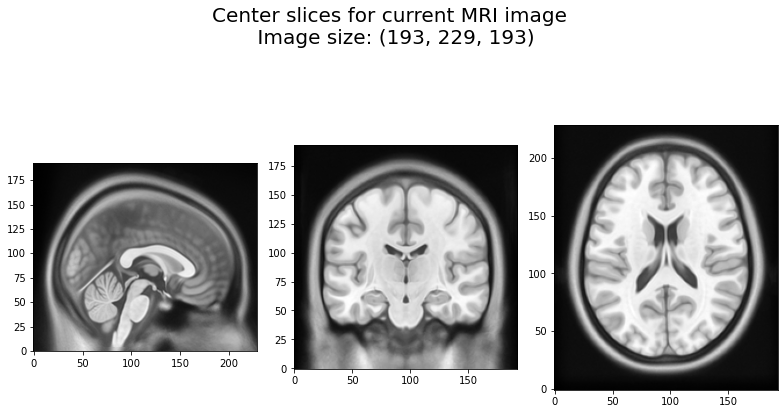

In [72]:
atlas = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/playground/utils/s3/Atlas/atlas_t1.nii'
atlas_img = nib.load(atlas).get_fdata()
show_brain_center_slice(atlas_img)

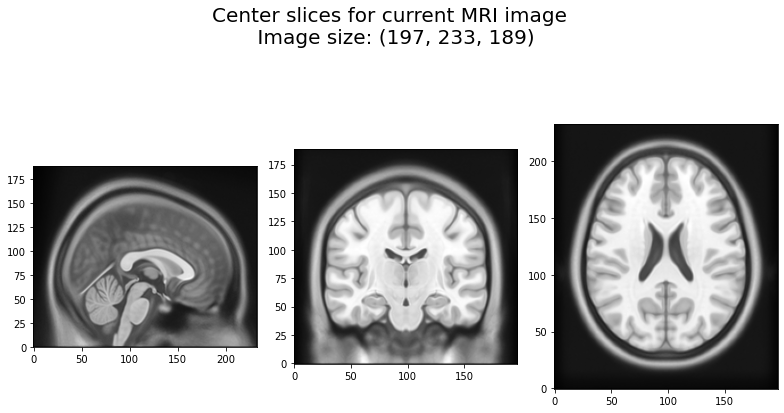

In [80]:
atlas_dir = '/home/lucasthim1//alzheimer_bucket/atlas/ICBM152_2009a_nonlinear_symmetric/'
# os.listdir(atlas_dir)
atlas =atlas_dir + 'mni_icbm152_t1_tal_nlin_sym_09a.nii'
atlas_img = nib.load(atlas).get_fdata()
show_brain_center_slice(atlas_img)